In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn plotly prophet keras tensorflow streamlit pyarrow

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For machine learning models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# For deep learning
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# For Prophet
from prophet import Prophet

# For visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For API calls (weather data)
import requests
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [2]:
# Load the UCI household power consumption dataset
# Note: In Colab, you can upload the file directly or load from a URL
# This is a sample - replace with actual dataset path
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"

# Download and extract the data
!wget {url}
!unzip household_power_consumption.zip

# Load the data (this is a large file, so we'll load it in chunks)
column_names = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
                'Voltage', 'Global_intensity', 'Sub_metering_1',
                'Sub_metering_2', 'Sub_metering_3']

# Read the data in chunks
chunk_size = 100000
data_chunks = pd.read_csv('household_power_consumption.txt', sep=';',
                          low_memory=False, na_values=['?'],
                          chunksize=chunk_size, parse_dates={'DateTime': ['Date', 'Time']},
                          infer_datetime_format=True)

# Combine chunks into a single DataFrame
df = pd.concat(data_chunks)

# Display basic info
print(f"Dataset shape: {df.shape}")
print(df.info())
print(df.head())

# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, api_key, start_date, end_date):
    """
    Fetch historical weather data from OpenWeatherMap API
    Note: This requires a subscription for historical data
    """
    base_url = "https://api.openweathermap.org/data/2.5/onecall/timemachine"
    weather_data = []

    current_date = start_date
    while current_date <= end_date:
        timestamp = int(current_date.timestamp())
        url = f"{base_url}?lat={lat}&lon={lon}&dt={timestamp}&appid={api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            weather_data.append(response.json())
        current_date += timedelta(days=1)

    # Process the weather data into a DataFrame
    processed_data = []
    for day_data in weather_data:
        for hour_data in day_data['hourly']:
            processed_data.append({
                'DateTime': datetime.fromtimestamp(hour_data['dt']),
                'Temperature': hour_data['temp'] - 273.15,  # Convert to Celsius
                'Humidity': hour_data['humidity'],
                'WindSpeed': hour_data.get('wind_speed', 0),
                'WeatherCondition': hour_data['weather'][0]['main']
            })

    return pd.DataFrame(processed_data)

# Example usage (replace with actual API key and coordinates)
# api_key = "your_api_key_here"
# weather_df = get_weather_data(48.8566, 2.3522, api_key,
#                              datetime(2006, 12, 16), datetime(2010, 11, 26))
# print(weather_df.head())

--2025-05-08 14:58:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘household_power_consumption.zip’

household_power_con     [     <=>            ]  19.68M  22.6MB/s    in 0.9s    

2025-05-08 14:58:37 (22.6 MB/s) - ‘household_power_consumption.zip’ saved [20640916]

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  
Dataset shape: (2075259, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   DateTime               object 
 1   Global_active_power    float64
 2   Global_reactive_power  float64
 3   Voltage                fl

In [3]:
# Data Cleaning
def clean_data(df):
    # Convert DateTime to datetime object if not already
    if not pd.api.types.is_datetime64_any_dtype(df['DateTime']):
        df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Set DateTime as index
    df.set_index('DateTime', inplace=True)

    # Sort by DateTime
    df.sort_index(inplace=True)

    # Check for missing values
    print("Missing values before cleaning:")
    print(df.isnull().sum())

    # Forward fill missing values (alternative: interpolate)
    df.fillna(method='ffill', inplace=True)

    # If still missing values at start, backfill
    df.fillna(method='bfill', inplace=True)

    # Check for duplicates
    print(f"\nNumber of duplicates: {df.duplicated().sum()}")
    df = df[~df.duplicated()]

    # Ensure numeric columns are float type
    numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Final check for missing values
    print("\nMissing values after cleaning:")
    print(df.isnull().sum())

    return df

# Clean the data
df_clean = clean_data(df.copy())

# Resample to hourly frequency (original data is minute-level)
df_hourly = df_clean.resample('H').mean()

# Display cleaned data
print("\nCleaned hourly data:")
print(df_hourly.head())

Missing values before cleaning:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Number of duplicates: 168561

Missing values after cleaning:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Cleaned hourly data:
                     Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.

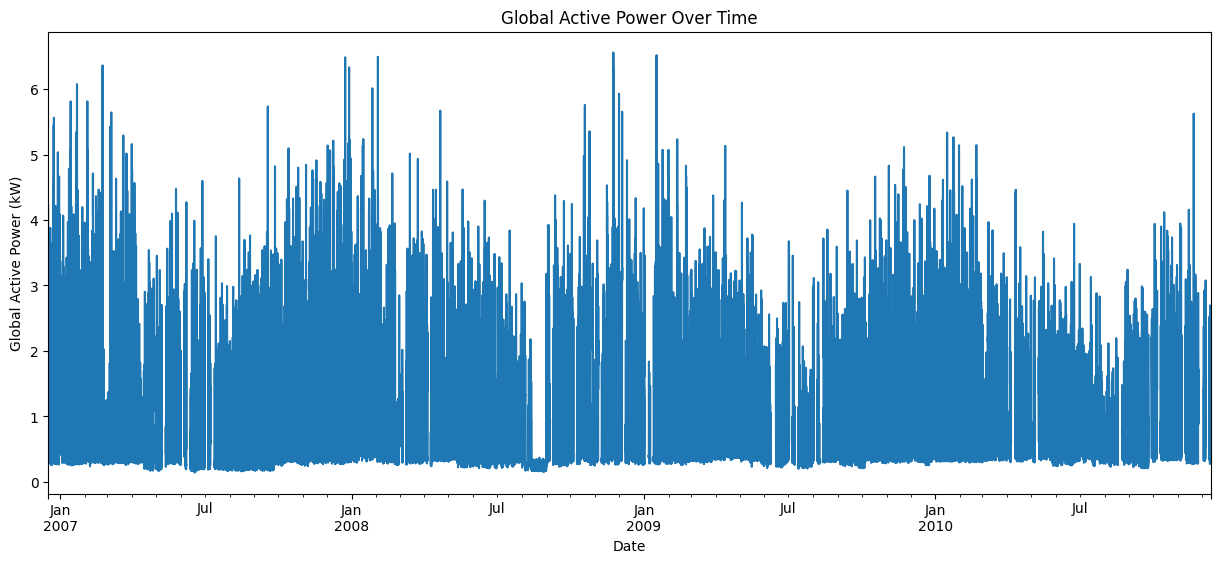

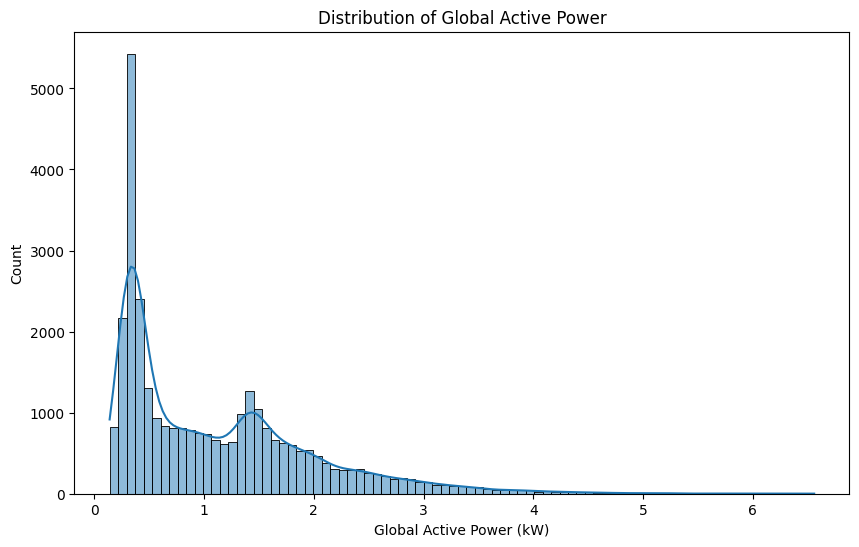

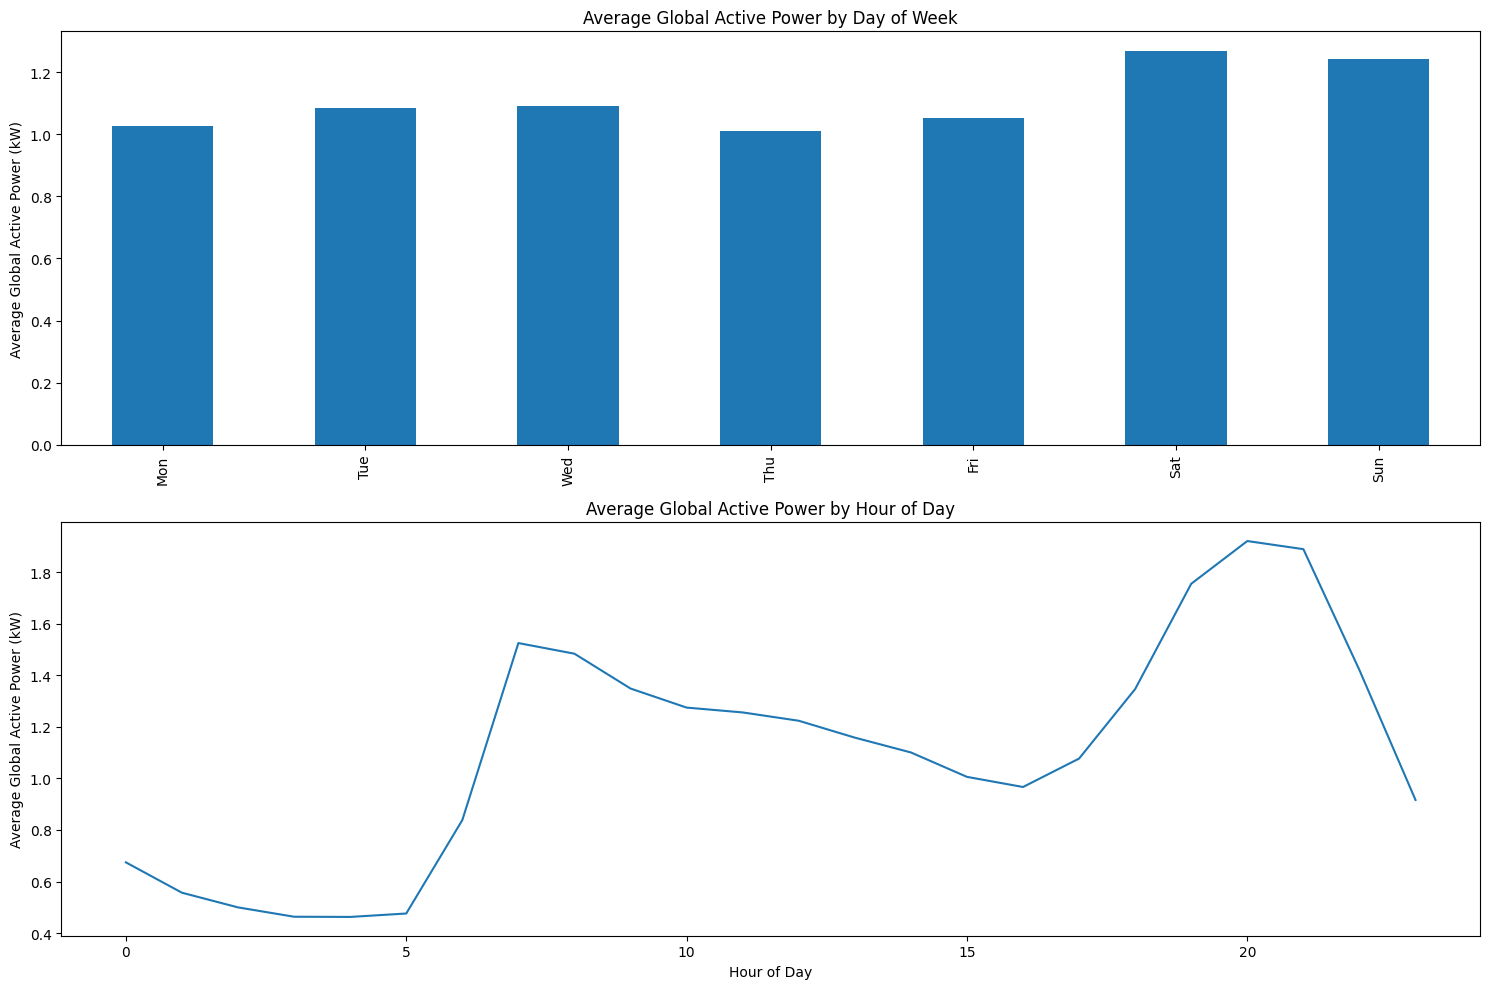

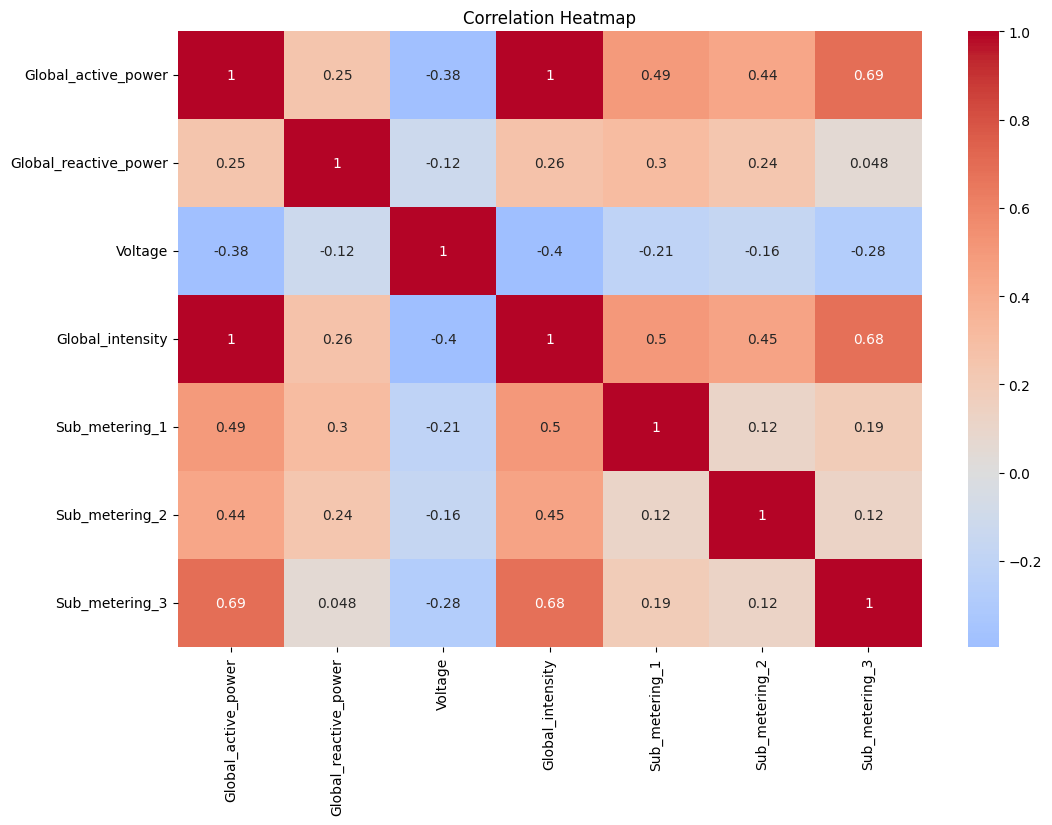

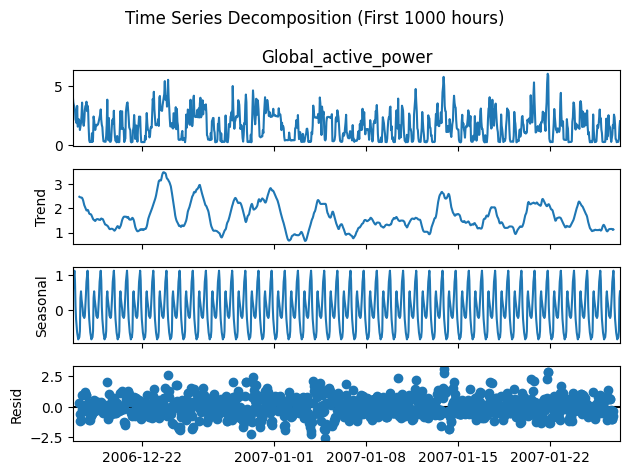

ADF Statistic: -14.34605664768633
p-value: 1.0405416766071127e-26
Critical Values:
   1%: -3.430558089416766
   5%: -2.8616319700509476
   10%: -2.5668189528248346


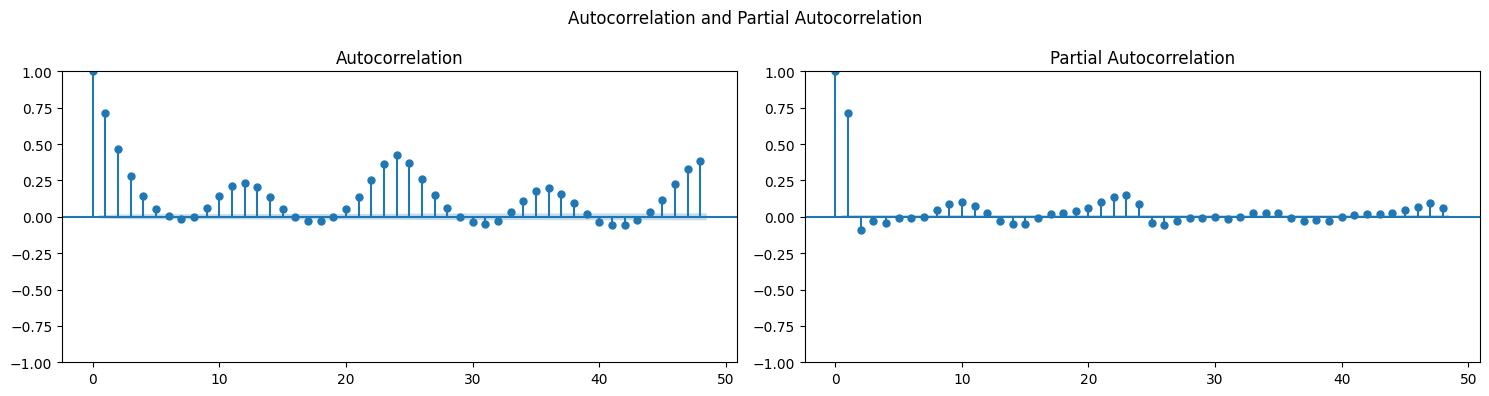

In [4]:
# EDA Functions
def perform_eda(df):
    # Plot time series of global active power
    plt.figure(figsize=(15, 6))
    df['Global_active_power'].plot(title='Global Active Power Over Time')
    plt.ylabel('Global Active Power (kW)')
    plt.xlabel('Date')
    plt.show()

    # Plot distribution of global active power
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Global_active_power'], kde=True)
    plt.title('Distribution of Global Active Power')
    plt.xlabel('Global Active Power (kW)')
    plt.show()

    # Plot weekly and daily patterns
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Weekly pattern
    weekly_pattern = df.groupby(df.index.dayofweek)['Global_active_power'].mean()
    weekly_pattern.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    weekly_pattern.plot(kind='bar', ax=axes[0], title='Average Global Active Power by Day of Week')
    axes[0].set_ylabel('Average Global Active Power (kW)')

    # Daily pattern
    hourly_pattern = df.groupby(df.index.hour)['Global_active_power'].mean()
    hourly_pattern.plot(kind='line', ax=axes[1], title='Average Global Active Power by Hour of Day')
    axes[1].set_ylabel('Average Global Active Power (kW)')
    axes[1].set_xlabel('Hour of Day')

    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()

    # Time series decomposition
    try:
        decomposition = seasonal_decompose(df['Global_active_power'].iloc[:1000],
                                         period=24, model='additive')  # Daily seasonality
        decomposition.plot()
        plt.suptitle('Time Series Decomposition (First 1000 hours)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Decomposition error: {e}")

    # ADF test for stationarity
    result = adfuller(df['Global_active_power'].dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    # ACF and PACF plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(df['Global_active_power'].dropna(), lags=48, ax=axes[0])  # 48 hours (2 days)
    plot_pacf(df['Global_active_power'].dropna(), lags=48, ax=axes[1])
    plt.suptitle('Autocorrelation and Partial Autocorrelation')
    plt.tight_layout()
    plt.show()

# Perform EDA on hourly data
perform_eda(df_hourly)

In [5]:
# Feature Engineering
def add_features(df):
    # Time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Lag features
    df['lag_24h'] = df['Global_active_power'].shift(24)  # Previous day same hour
    df['lag_168h'] = df['Global_active_power'].shift(168)  # Previous week same hour

    # Rolling statistics
    df['rolling_24h_mean'] = df['Global_active_power'].rolling(window=24).mean()
    df['rolling_24h_std'] = df['Global_active_power'].rolling(window=24).std()
    df['rolling_7d_mean'] = df['Global_active_power'].rolling(window=168).mean()

    # Difference features
    df['diff_24h'] = df['Global_active_power'].diff(24)
    df['diff_168h'] = df['Global_active_power'].diff(168)

    # Drop rows with NaN values created by lag and rolling features
    df.dropna(inplace=True)

    return df

# Add features to the dataset
df_features = add_features(df_hourly.copy())

# Display features
print("Data with additional features:")
print(df_features.head())

# If weather data is available, merge it here
# df_features = pd.merge(df_features, weather_df, left_index=True, right_on='DateTime', how='left')
# df_features.set_index('DateTime', inplace=True)

Data with additional features:
                     Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                                      
2006-12-23 17:00:00             5.452533               0.215967  233.644167   
2006-12-23 18:00:00             3.879400               0.099767  238.000500   
2006-12-23 19:00:00             4.117833               0.205333  238.729333   
2006-12-23 20:00:00             4.181400               0.124767  238.518833   
2006-12-23 21:00:00             3.288433               0.235767  238.594667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-23 17:00:00         23.360000       16.183333        0.666667   
2006-12-23 18:00:00         16.363333        0.000000        0.016667   
2006-12-23 19:00:00         17.300000        0.000000        0.600000   
2006-12-23 20:00:00         17.596667        0.000

In [6]:
# Prepare data for modeling
target = 'Global_active_power'
features = [col for col in df_features.columns if col != target]

# Split into train and test sets (last 30 days for testing)
test_size = 24 * 30  # 30 days
train = df_features.iloc[:-test_size]
test = df_features.iloc[-test_size:]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Split into X and y
X_train = train_scaled[:, 1:]  # All columns except the first (target)
y_train = train_scaled[:, 0]
X_test = test_scaled[:, 1:]
y_test = test_scaled[:, 0]

# Reshape for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Helper function for evaluating models
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")

    return rmse, mae, mape

# ARIMA Model
def run_arima(train, test):
    # Fit ARIMA model
    model = ARIMA(train[target], order=(5,1,0))  # Example order, should be tuned
    model_fit = model.fit()

    # Forecast
    arima_forecast = model_fit.forecast(steps=len(test))

    # Evaluate
    rmse, mae, mape = evaluate_model(test[target], arima_forecast, "ARIMA")

    return arima_forecast, (rmse, mae, mape)

# SARIMA Model
def run_sarima(train, test):
    # Fit SARIMA model
    model = SARIMAX(train[target],
                   order=(1, 1, 1),
                   seasonal_order=(1, 1, 1, 24))  # Example parameters, should be tuned
    model_fit = model.fit(disp=False)

    # Forecast
    sarima_forecast = model_fit.forecast(steps=len(test))

    # Evaluate
    rmse, mae, mape = evaluate_model(test[target], sarima_forecast, "SARIMA")

    return sarima_forecast, (rmse, mae, mape)

# LSTM Model
def run_lstm(X_train, y_train, X_test, y_test):
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Fit model
    history = model.fit(X_train, y_train,
                       epochs=50,
                       batch_size=32,
                       validation_split=0.2,
                       callbacks=[early_stop],
                       verbose=0)

    # Predict
    lstm_forecast = model.predict(X_test).flatten()

    # Evaluate
    rmse, mae, mape = evaluate_model(y_test, lstm_forecast, "LSTM")

    return lstm_forecast, (rmse, mae, mape), history

# Prophet Model
def run_prophet(train, test):
    # Prepare data for Prophet
    prophet_train = train[[target]].reset_index()
    prophet_train.columns = ['ds', 'y']

    # Fit model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.add_country_holidays(country_name='FR')  # Assuming data is from France
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=len(test), freq='H')

    # Forecast
    forecast = model.predict(future)
    prophet_forecast = forecast['yhat'].iloc[-len(test):].values

    # Evaluate
    rmse, mae, mape = evaluate_model(test[target], prophet_forecast, "Prophet")

    return prophet_forecast, (rmse, mae, mape), model

# Run all models
print("Running ARIMA...")
arima_forecast, arima_metrics = run_arima(train, test)

print("\nRunning SARIMA...")
sarima_forecast, sarima_metrics = run_sarima(train, test)

print("\nRunning LSTM...")
lstm_forecast, lstm_metrics, lstm_history = run_lstm(X_train_lstm, y_train, X_test_lstm, y_test)

print("\nRunning Prophet...")
prophet_forecast, prophet_metrics, prophet_model = run_prophet(train, test)

# Compare all models
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'LSTM', 'Prophet'],
    'RMSE': [arima_metrics[0], sarima_metrics[0], lstm_metrics[0], prophet_metrics[0]],
    'MAE': [arima_metrics[1], sarima_metrics[1], lstm_metrics[1], prophet_metrics[1]],
    'MAPE': [arima_metrics[2], sarima_metrics[2], lstm_metrics[2], prophet_metrics[2]]
})

print("\nModel Comparison:")
print(metrics_df)

Train shape: (25331, 19)
Test shape: (720, 19)
Running ARIMA...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA Performance:
RMSE: 0.9434
MAE: 0.6643
MAPE: nan%

Running SARIMA...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


SARIMA Performance:
RMSE: 0.7741
MAE: 0.6197
MAPE: nan%

Running LSTM...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
LSTM Performance:
RMSE: 0.0021
MAE: 0.0014
MAPE: 2.0863%

Running Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmprnncuo3h/oej2hz6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprnncuo3h/mw3o6ll9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5783', 'data', 'file=/tmp/tmprnncuo3h/oej2hz6n.json', 'init=/tmp/tmprnncuo3h/mw3o6ll9.json', 'output', 'file=/tmp/tmprnncuo3h/prophet_modelasnpll4a/prophet_model-20250508150548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Performance:
RMSE: 0.8346
MAE: 0.6393
MAPE: 96.0352%

Model Comparison:
     Model      RMSE       MAE       MAPE
0    ARIMA  0.943432  0.664274        NaN
1   SARIMA  0.774052  0.619681        NaN
2     LSTM  0.002150  0.001440   2.086289
3  Prophet  0.834581  0.639315  96.035180


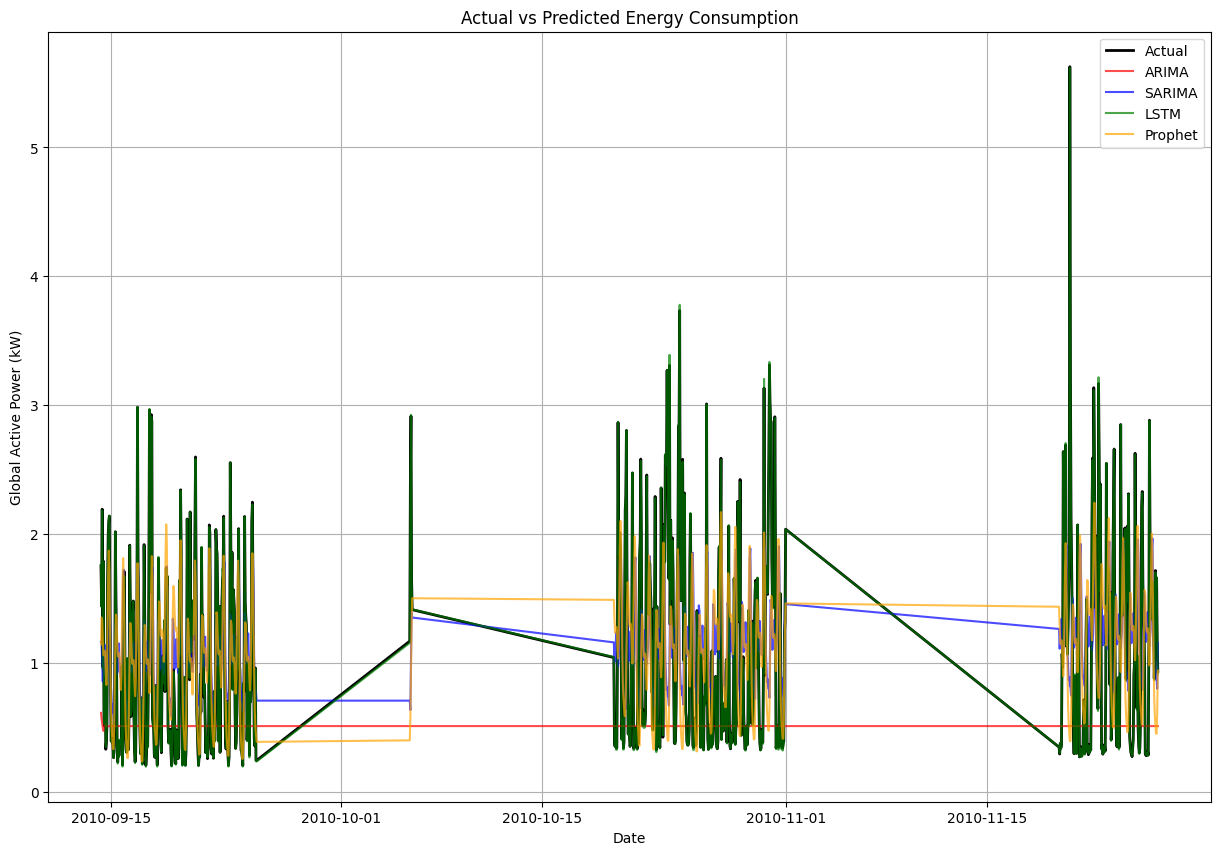

In [8]:
# Time Series Cross-Validation
def timeseries_cv(model_type, df, target, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = {'RMSE': [], 'MAE': [], 'MAPE': []}

    for train_index, test_index in tscv.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]

        if model_type == 'arima':
            forecast, (rmse, mae, mape) = run_arima(train, test)
        elif model_type == 'sarima':
            forecast, (rmse, mae, mape) = run_sarima(train, test)
        elif model_type == 'prophet':
            forecast, (rmse, mae, mape), _ = run_prophet(train, test)
        else:
            raise ValueError("Invalid model type")

        metrics['RMSE'].append(rmse)
        metrics['MAE'].append(mae)
        metrics['MAPE'].append(mape)

    # Calculate average metrics
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    return avg_metrics

# Example usage (commented out as it's time-consuming)
# print("ARIMA CV Metrics:", timeseries_cv('arima', df_features, target))
# print("SARIMA CV Metrics:", timeseries_cv('sarima', df_features, target))
# print("Prophet CV Metrics:", timeseries_cv('prophet', df_features, target))

# Plot actual vs predicted for all models
def plot_predictions(test, predictions_dict):
    plt.figure(figsize=(15, 10))

    # Plot actual values
    plt.plot(test.index, test[target], label='Actual', color='black', linewidth=2)

    # Plot each model's predictions
    colors = ['red', 'blue', 'green', 'orange']
    for i, (model_name, pred) in enumerate(predictions_dict.items()):
        plt.plot(test.index, pred, label=model_name, color=colors[i], alpha=0.7)

    plt.title('Actual vs Predicted Energy Consumption')
    plt.ylabel('Global Active Power (kW)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create predictions dictionary
predictions = {
    'ARIMA': arima_forecast,
    'SARIMA': sarima_forecast,
    'LSTM': lstm_forecast * (df_features[target].max() - df_features[target].min()) + df_features[target].min(),  # Inverse scaling
    'Prophet': prophet_forecast
}

# Plot predictions
plot_predictions(test, predictions)

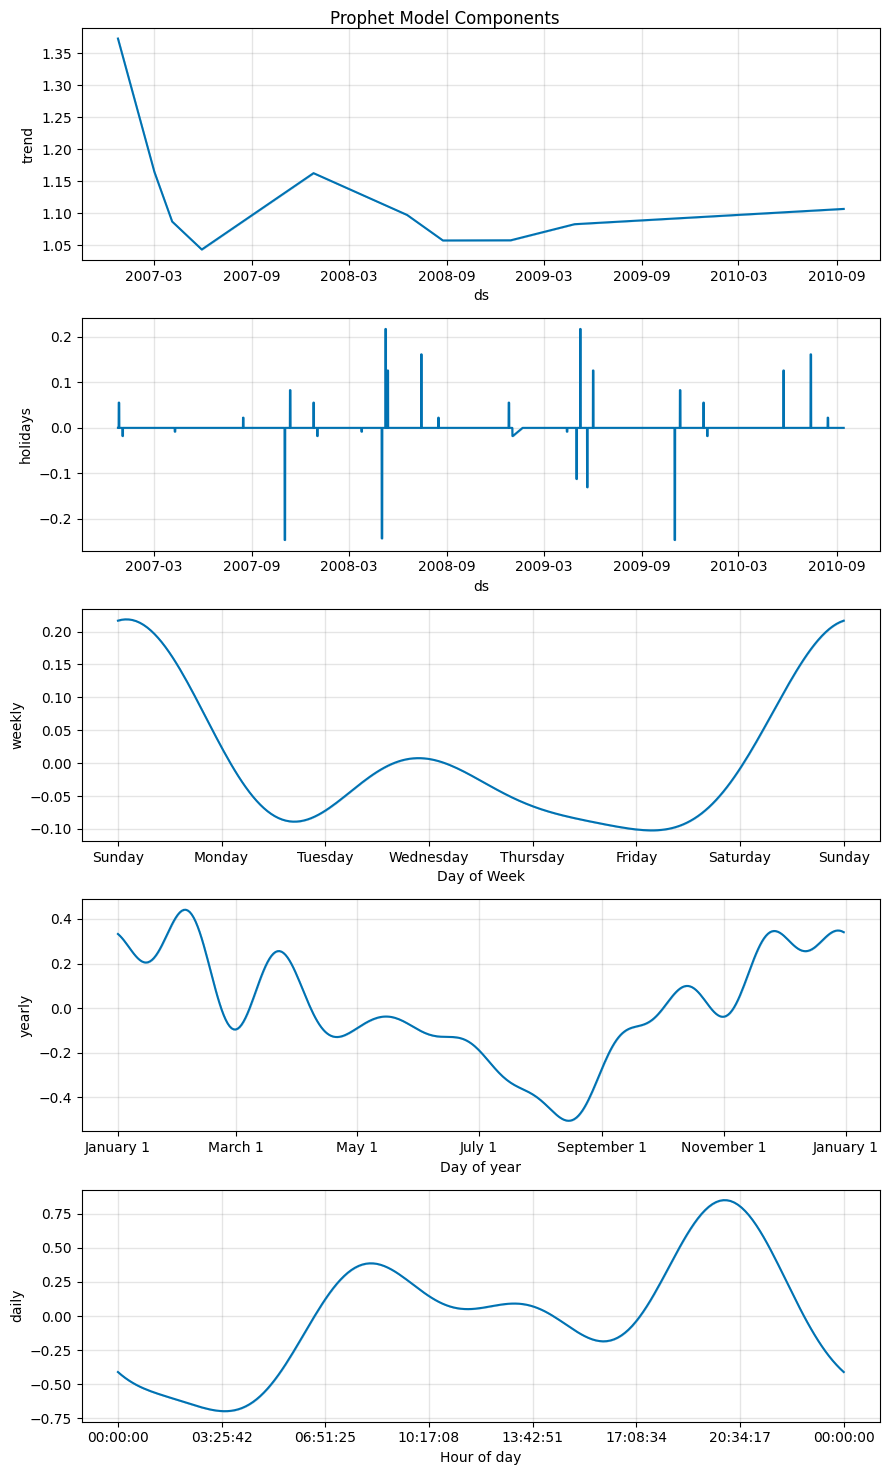

In [9]:
# Interactive Visualization with Plotly
def interactive_visualization(test, predictions):
    fig = go.Figure()

    # Add actual values
    fig.add_trace(go.Scatter(x=test.index, y=test[target],
                            mode='lines',
                            name='Actual',
                            line=dict(color='black', width=2)))

    # Add model predictions
    colors = ['red', 'blue', 'green', 'orange']
    for i, (model_name, pred) in enumerate(predictions.items()):
        fig.add_trace(go.Scatter(x=test.index, y=pred,
                                mode='lines',
                                name=model_name,
                                line=dict(color=colors[i], width=1.5)))

    # Update layout
    fig.update_layout(title='Actual vs Predicted Energy Consumption',
                     xaxis_title='Date',
                     yaxis_title='Global Active Power (kW)',
                     hovermode='x unified',
                     template='plotly_white')

    fig.show()

# Display interactive plot
interactive_visualization(test, predictions)

# Feature Importance for LSTM (if using feature engineering)
def plot_feature_importance(model, feature_names):
    # Get weights from the first LSTM layer
    weights = model.layers[0].get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)

    # Create DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance[:len(feature_names)]  # Only take as many as features
    }).sort_values('Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('LSTM Feature Importance')
    plt.tight_layout()
    plt.show()

# Example usage (if using feature engineering)
# plot_feature_importance(lstm_model, features)

# Prophet components plot
if 'prophet_model' in locals():
    fig = prophet_model.plot_components(prophet_model.predict(prophet_model.make_future_dataframe(periods=0)))
    plt.suptitle('Prophet Model Components')
    plt.tight_layout()
    plt.show()